In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter

In [38]:
# get data from s3
url = "https://s3.amazonaws.com/survival2024/hurricane.csv"
df = pd.read_csv(url)

In [39]:
#check for motor failure
df['motor']=0
df.loc[df['reason'] == 2, 'motor'] = 1

## Cox regression on Original DF
Building cox model w/ motor failure censored.

In [40]:
cph = CoxPHFitter()
#backwards selction at alpha 0.03
cph.fit(df[['backup', 'age', 'bridgecrane', 'servo', 'gear', 'trashrack', 'slope', 'elevation', 'hour', 'motor']], duration_col='hour', event_col='motor')
cph.fit(df[['backup', 'age', 'bridgecrane', 'servo', 'gear', 'slope', 'elevation', 'hour', 'motor']], duration_col='hour', event_col='motor')
cph.fit(df[['backup', 'age', 'bridgecrane', 'servo', 'gear', 'slope', 'hour', 'motor']], duration_col='hour', event_col='motor')
cph.fit(df[['backup', 'age', 'bridgecrane', 'servo', 'slope', 'hour', 'motor']], duration_col='hour', event_col='motor')
cph.fit(df[['age', 'bridgecrane', 'servo', 'slope', 'hour', 'motor']], duration_col='hour', event_col='motor')
cph.fit(df[['age', 'servo', 'slope', 'hour', 'motor']], duration_col='hour', event_col='motor')

cph.print_summary()


<lifelines.CoxPHFitter: fitted with 770 total observations, 658 right-censored observations>
             duration col = 'hour'
                event col = 'motor'
      baseline estimation = breslow
   number of observations = 770
number of events observed = 112
   partial log-likelihood = -613.86
         time fit was run = 2024-11-20 17:54:23 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
age       -1.52      0.22      0.17           -1.85           -1.18                0.16                0.31
servo      0.44      1.55      0.20            0.04            0.84                1.04                2.32
slope     -0.29      0.75      0.07           -0.42           -0.16                0.66                0.85

           cmp to     z      p  -log2(p)
covariate                               
age          0.00 -8.90 <0.005     60.60
servo        0.00  2.16   0.03      5.02
slope        0.00 -4.36 <0.005     16.24
---
Concordance = 0.79
Partial AIC = 1233.71
log-likelihood ratio test = 132.89 on 3 df
-log2(p) of ll-ratio test = 92.64

After backwards selection we have to check assumptions


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.


[[<Axes: xlabel='rank-transformed time\n(p=0.9614)'>,
  <Axes: xlabel='km-transformed time\n(p=0.1743)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.8880)'>,
  <Axes: xlabel='km-transformed time\n(p=0.9653)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.5220)'>,
  <Axes: xlabel='km-transformed time\n(p=0.5812)'>]]

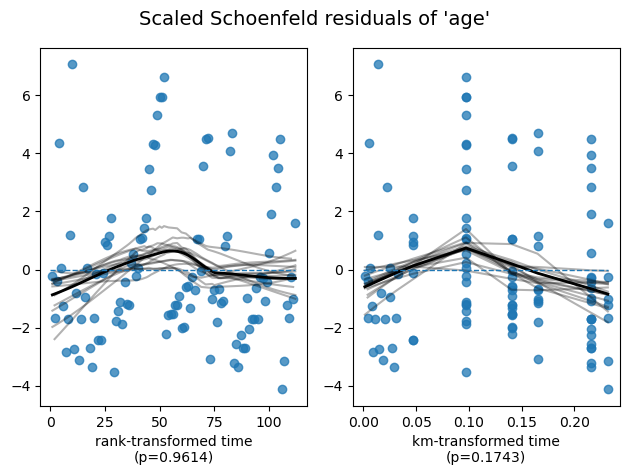

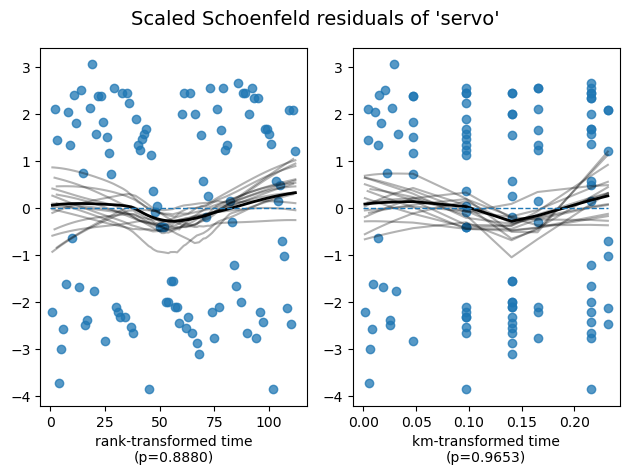

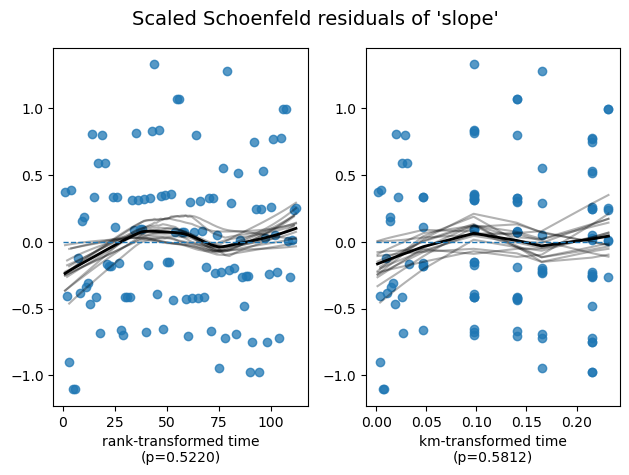

In [41]:
cph.check_assumptions(df[['age', 'servo', 'slope', 'hour', 'motor']], p_value_threshold=0.03, show_plots=True)

## Pivoiting DF
Add column if motor is constantly running for 12 hours.

In [42]:
#grab hour columns but first rename hour column
df = df.rename(columns={'hour': 'failure_hour'})
hour_columns = [col for col in df.columns if col.startswith('h')]

#fill na's in the hour_columns with 0's, I'm assuming that since they are missing they are not turned on
df[hour_columns] = df[hour_columns].fillna(0)

#add pump numbers to df
df = df.reset_index(names='pump')

#melt df to reshape it
df_long = df.melt(
    id_vars=[col for col in df.columns if col not in hour_columns],  # Static columns to keep
    value_vars=hour_columns,  # Columns to unpivot
    var_name='run_hour_stop',  # New column name for hour labels
    value_name='running'  # Values from the hour columns
)

#grab numeric hour
df_long['run_hour_stop'] = df_long['run_hour_stop'].str.extract(r'(\d+)').astype(float).fillna(-1).astype(int)

#create a continous runtime column. how many hours has runnning=0 in a row
df_long['continuous_runtime'] = (
    df_long.groupby('pump')['running']
    .cumsum() * df_long['running']
)

df_long = df_long.sort_values(['pump', 'run_hour_stop']).reset_index(drop=True)
df_long.head()


,pump,backup,age,bridgecrane,servo,gear,trashrack,slope,elevation,survive,failure_hour,reason,reason2,motor,run_hour_stop,running,continuous_runtime
0,0,0,6.0,0,0,0,1,3,2,1,48,0,5,0,1,1.0,1.0
1,0,0,6.0,0,0,0,1,3,2,1,48,0,5,0,2,1.0,2.0
2,0,0,6.0,0,0,0,1,3,2,1,48,0,5,0,3,1.0,3.0
3,0,0,6.0,0,0,0,1,3,2,1,48,0,5,0,4,1.0,4.0
4,0,0,6.0,0,0,0,1,3,2,1,48,0,5,0,5,1.0,5.0


Now I'm going to grab only the columns in which I need to predict.  
`age`, `servo`, `slope`

In [43]:
df_motor = df_long[['pump', 'age', 'servo', 'slope', 'failure_hour', 'motor', 'run_hour_stop', 'continuous_runtime']]
df_motor = df_motor.copy()
df_motor['12+'] = (df_motor['continuous_runtime'] >= 12).astype(int)
df_motor['run_hour_start'] = df_motor['run_hour_stop']-1
df_motor.head()

,pump,age,servo,slope,failure_hour,motor,run_hour_stop,continuous_runtime,12+,run_hour_start
0,0,6.0,0,3,48,0,1,1.0,0,0
1,0,6.0,0,3,48,0,2,2.0,0,1
2,0,6.0,0,3,48,0,3,3.0,0,2
3,0,6.0,0,3,48,0,4,4.0,0,3
4,0,6.0,0,3,48,0,5,5.0,0,4


## Cox Model on Pivot Data
Using the prevoisly identified import variables and the new 12+ hour flag we created

In [46]:
cph.fit(df_motor, duration_col='run_hour_stop', event_col='motor')
cph.print_summary()


<lifelines.CoxPHFitter: fitted with 36960 total observations, 31584 right-censored observations>
             duration col = 'run_hour_stop'
                event col = 'motor'
      baseline estimation = breslow
   number of observations = 36960
number of events observed = 5376
   partial log-likelihood = -34546.43
         time fit was run = 2024-11-20 17:56:39 UTC

---
                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                           
pump                0.01      1.01      0.00            0.01            0.01                1.01                1.01
age                -1.16      0.31      0.02           -1.20           -1.13                0.30                0.32
servo               0.10      1.10      0.03            0.03            0.16                1.04                1.17
slope              -0.38      0.68      0.01           -0.40           -0.36                0.67                0.69
failure_hour        0.09      1.09      0.00            0.08            0.09                1.09                1.10
continuous_runtime -0.01      0.99      0.00           -0.01           -0.00                0.99                1.00
12+                 0.08      1.08      0.07           -0.06            0.21                0.94                1.24
run_hour_start     -0.51      0.60      0.01           -0.53           -0.50                0.59                0.61

                    cmp to      z      p  -log2(p)
covariate                                         
pump                  0.00  56.62 <0.005       inf
age                   0.00 -64.52 <0.005       inf
servo                 0.00   3.10 <0.005      9.00
slope                 0.00 -39.33 <0.005       inf
failure_hour          0.00  41.57 <0.005       inf
continuous_runtime    0.00  -2.48   0.01      6.24
12+                   0.00   1.12   0.26      1.93
run_hour_start        0.00 -68.58 <0.005       inf
---
Concordance = 0.99
Partial AIC = 69108.86
log-likelihood ratio test = 33806.77 on 8 df
-log2(p) of ll-ratio test = inf